<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

* Watch tutorial

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
  
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)

In [7]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
validation_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
model = ConvNetwork(train_dataset)
model = model.cuda()

objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=42, pin_memory=True)

losses = []
validations = []
total_accuracy_train = []
total_accuracy_val = []
validation_accuracy_mean = []


num_epochs = 2



for epoch in range(num_epochs):
  # train
  loop = tqdm(total=len(train_loader) * num_epochs, position=0)

  for batch, (x, y_truth) in enumerate(train_loader):
    # learn
    # Change back to .cuda() (after =)
    x, y_truth = x.cuda(), y_truth.cuda()
    optimizer.zero_grad()
    y_hat = model(x)


    loss = objective(y_hat, y_truth)

    loss.backward()
    optimizer.step()



    losses.append(loss.item())
    loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, batch, loss.item()))
    loop.update(1)

    # Accuracy from video
    if batch % 100 == 0:
      acc = torch.softmax(y_hat, dim=1).argmax(dim=1)
      actual_accuracy = (acc == y_truth).float().mean()
      total_accuracy_train.append((batch, actual_accuracy.item()))

    

    if batch % 500 == 0:
      # Change x, y back to .cuda()
      val = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in validation_loader])
      total_accuracy_val = []

      for batch, (x_validation, y_truth_validation) in enumerate(validation_loader):
        # print(f"x_validation: {x_validation}")
        x_validation, y_truth_validation = x_validation.cuda(), y_truth_validation.cuda()

        # Get predictions for how well the model is doing on the validation data.
        y_hat_validation = model(x_validation)

        # Compute the probability of each class for each image, 
        validation_acc = torch.softmax(y_hat_validation, dim=1).argmax(dim=1)
        total_accuracy_val.append(((validation_acc == y_truth_validation).float().mean()).item())
      # print(total_accuracy_val)
      
      validation_accuracy_mean_val = np.mean(total_accuracy_val)
      validations.append((len(losses), val))
    
      # This list has the average accuracy for every 500 batches.
      validation_accuracy_mean.append((batch, validation_accuracy_mean_val))



      
  loop.close()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



epoch:1, loss:1428.0000:  50%|█████     | 1429/2858 [00:58<00:58, 24.55it/s]


In [15]:
e = []
for i in range(30):
  e.append(i*100)

print(e)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900]


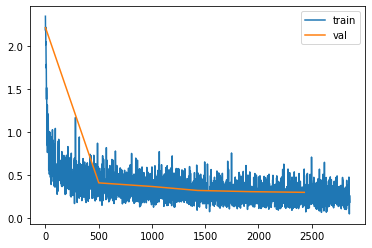

In [8]:
a, b = zip(*validations)
c, d = zip(*validation_accuracy_mean)
e, f = zip(*total_accuracy_train)
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

**DONE:**
* Conv2D
* CrossEntropyLoss

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform



In [4]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None,
              reduction='mean', label_smoothing=0.0):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, y_hat, y_truth): 
    # Creating a tensor contaning only the y_hat values for the class of the image.
    #print(f"y_hat.size(): {y_hat.size}")
    selected_values = y_hat[torch.arange(len(y_hat)), y_truth]
    # Doing a lot of math on the y_hat values by row
    math_values = torch.logsumexp(y_hat, 1)
    loss = math_values-selected_values
    return loss.mean()

#    numerator = torch.exp(y_hat)
#    denominator = numerator.sum(0, keepdim=True)
#
#    #soft_max loop
#    soft_max = []
#    for i in range(42):
#      soft_max_value = numerator[i,:]/denominator[i]
#      soft_max.append(soft_max_value)
#    soft_max = torch.stack(soft_max)
#    soft_max = soft_max.cuda()
#
#    #cross_entropy_loss loop (using one_hot encoding)
#    batch_size, classes = y_hat.size()
#    one_hot = torch.zeros((batch_size, classes))
#    one_hot[np.arange(batch_size), y_truth] = 1
#    one_hot = one_hot.cuda()
#
#    loss = []
#    for j in range(len(soft_max)):
#      loss_val = -torch.log(torch.sum(soft_max[j]*one_hot[j].cuda()))
#      loss.append(loss_val)
#    loss = torch.stack(loss)
#
#    return loss.mean()
    

    

class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
               groups=1, bias=True, padding_mode='zeros', device=None, dtype=None, init_strategy='xav'):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(out_channels,
                               in_channels, 
                               kernel_size[0],
                               kernel_size[1]))  # 4-dimensional tensor of (out, in, k1, k2)
    self.bias = Parameter(torch.Tensor(out_channels))

    self.weight.data.uniform_(-1,1)
    self.bias.data.uniform_(0,0)

    if init_strategy == 'xav':
      a_value = np.sqrt((6)/(in_channels*kernel_size[0]*kernel_size[1] + out_channels))
      range = (-a_value, a_value)
      self.weight.data.uniform_(-a_value, a_value)

    elif init_strategy == 'ortho':
      X = np.random.random(out_channels, in_channels*kernel_size[0]*kernel_size[1])
      U, Eps, Vt = np.linalg.svd(X, full_matrices=False)
      W = Vt.reshape((out_channels, in_channels, kernel_size[0], kernel_size[1]))  # Reshaping as done in the article
      self.weight.data = torch.from_numpy(W)   # Applying the new weight initialization to the weights.

    elif init_strategy == 'unif':
      self.weight.data.uniform_(-2,2)

    else:
      lower_bound, upper_bound = torch.sqrt((6)/(in_channels + out_channels))
      range = (-lower_bound, upper_bound)
      self.weight.data.uniform_(-lower_bound, upper_bound)
      

    # initialize these
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)


In [5]:
# Creating our network class
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(
        Conv2d(c, 8, (3,3), padding=(1,1), init_strategy="xav"),
        nn.ReLU(),
        Conv2d(8, 60, (3,3), padding=(1,1), init_strategy="xav"),
        nn.ReLU(),
        Conv2d(60, 250, (3,3), padding=(1,1), init_strategy="xav"),
        nn.ReLU(),
        Conv2d(250, 100, (3,3), padding=(1,1), init_strategy="xav"),
        nn.ReLU(),
        Conv2d(100, 48, (3,3), padding=(1,1), init_strategy="xav"),
        nn.ReLU(),
        Conv2d(48, output, (28, 28), padding=(0,0), init_strategy="xav")
        )
    
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

In [ ]:
# Initialize Datasets

# Initialize DataLoaders

# Initialize Model

# Initialize Objective and Optimizer and other parameters


In [ ]:

# Run your training and validation loop and collect stats



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 
* Plot experiment results with 85% or better validation accuracy

**DONE:**


In [6]:
q = [0, 500, 1000, 1500, 2000, 2500]

<function matplotlib.pyplot.show>

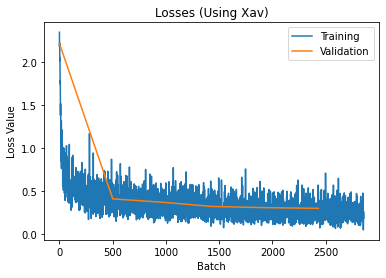

In [10]:
# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy
plt.plot(losses, label="Training")
plt.plot(a, b, label="Validation")
plt.title("Losses (Using Xav)")
plt.xlabel("Batch")
plt.ylabel("Loss Value")
plt.legend()
plt.show




<function matplotlib.pyplot.show>

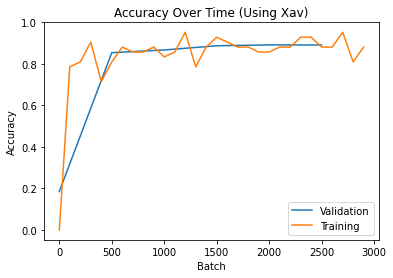

In [16]:
plt.plot(q, d, label="Validation")
plt.plot(e, f, label="Training")
plt.plot()
plt.title("Accuracy Over Time (Using Xav)")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.legend()
plt.show

In [ ]:
# Compute and print the number of parameters in the model
total_parameters = 0
for p in model.parameters():
  holder = []
  for s in p.size():
    holder.append(s)
  h = np.prod(holder)
  total_parameters += h
print(f"Total parameters in my model: {total_parameters}")

Total parameters in my model: 784388


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(1,1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3,3), padding=(2,2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3,3), padding=(6,6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,5), padding=(2,2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,5), padding=(3,3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,5), padding=(9,9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5,3), padding=(1,0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,3), padding=(2,1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,3), padding=(3,2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,3), padding=(9,8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **kernel_size=(2,4)**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **kernel_size=(1,1)**

**TODO:**

**DONE:**
* Answer all the questions above 

In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
